In [137]:
import torch
from model import AutoEncoder
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
from sklearn.metrics import davies_bouldin_score, silhouette_score, f1_score, recall_score, precision_score, accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

# load from ordered dict
# state_dict = torch.load('model.pth')
# # load from state dict
# model = AutoEncoder()
# model.load_state_dict(state_dict)
# model.eval()

#### Load and preprocess data

In [225]:
data = pd.read_csv('creditcard.csv')
X = data.drop(['Class', 'Amount', 'Time'], axis=1)
y = data['Class']

X_scale = MinMaxScaler().fit_transform(X)

# sample data to reduce class imbalance
non_fraud_df = X_scale[y == 0][:2000]
fraud_df = X_scale[y == 1]

X_sample = np.vstack([non_fraud_df, fraud_df])
fraud_idx = np.zeros(len(X_sample))
fraud_idx[-len(fraud_df):] = 1

indices = np.arange(len(X_sample))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_sample, fraud_idx, indices, test_size=0.2, random_state=42, stratify=fraud_idx)

In [245]:
def purity_score(X, y, cluster_labels) -> float:
    """
    Function to calculate the purity score. Which is a measure of how well a cluster contains only one class.
    It is calculated as the fraction of the dominant class in the cluster. The purity score is then adjusted based on the expected purity.
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    global_class_distribution = y.value_counts(normalize=True).to_dict() # this mihgt be wrong as we are using splits, but they are stratified so it should be okay
    # Compute metrics for each cluster, including adjusted purity
    cluster_purity = []
    cluster_weight = []

    for cluster_id in np.unique(cluster_labels):
        idx = np.where(cluster_labels == cluster_id)
        cluster_data = X[idx]
        total_in_cluster = len(cluster_data)
        
        # Compute class distribution within the cluster
        class_distribution = y.iloc[idx].value_counts(normalize=True)
        
        # Purity: Fraction of the dominant class in the cluster
        dominant_class = class_distribution.idxmax()
        purity = class_distribution[dominant_class]
        
        # Expected purity based on global distribution
        expected_purity = global_class_distribution[dominant_class]
        
        # Adjusted Purity
        if purity > expected_purity:
            adjusted_purity = (purity - expected_purity) / (1 - expected_purity)
        else:
            adjusted_purity = 0  # Set to 0 if purity is less than or equal to expected purity
        
        # Weighted purity
        cluster_purity.append(adjusted_purity)
        cluster_weight.append(total_in_cluster / len(X))
    
    # Compute the weighted average of cluster purity
    purity = np.sum(np.array(cluster_purity) * np.array(cluster_weight))
    return purity

def score_clustering(X, y, cluster_labels):
    return davies_bouldin_score(X, cluster_labels), silhouette_score(X, cluster_labels), purity_score(X, y, cluster_labels)

def clustering_classification_report(cluster_labels, class_labels, use_class_fraction=False):
    """
    Function to calculate the accuracy of a clustering algorithm. It does this by finding the most common class in each cluster and then mapping the cluster labels to the class labels.
    """
    df = pd.DataFrame({'cluster': cluster_labels, 'class': class_labels})

    # for each cluster find the class that is most common
    if use_class_fraction:
        cluster_class = df.groupby('cluster')['class'].apply(lambda x: 1 if (x.mean() > y.mean()) else 0) # here y is the global variable
    else:
        cluster_class = df.groupby('cluster')['class'].agg(lambda x:x.value_counts().index[0])

    # map the cluster labels to the class labels
    predicted_class = df['cluster'].map(cluster_class)
    # calculate the accuracy
    accuracy = accuracy_score(class_labels, predicted_class)
    f1 = f1_score(class_labels, predicted_class)
    recall = recall_score(class_labels, predicted_class)
    precision = precision_score(class_labels, predicted_class)
    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }
    return metrics
    

## Clustering on raw data

### Kmeans

In [97]:
def fit_kmeans(X_train, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    return kmeans

def extract_kmeans_cluster_labels(kmeans, X):
    return kmeans.predict(X)

def format_clustering_metrics(train_scores, test_scores, **kwargs):
    results = kwargs
    results.update({
        'Train_DB': train_scores[0],
        'Train_Sil': train_scores[1],
        'Train_Pur': train_scores[2],
        'Test_DB': test_scores[0],
        'Test_Sil': test_scores[1],
        'Test_Pur': test_scores[2],
    })
    return results

def format_classification_metrics(train_metrics, test_metrics, **kwargs):
    results = kwargs
    results.update({
        'Train_Acc': train_metrics['accuracy'],
        'Train_F1': train_metrics['f1'],
        'Train_Recall': train_metrics['recall'],
        'Train_Precision': train_metrics['precision'],
        'Test_Acc': test_metrics['accuracy'],
        'Test_F1': test_metrics['f1'],
        'Test_Recall': test_metrics['recall'],
        'Test_Precision': test_metrics['precision'],
    })
    return results

def evaluate_kmeans(X_train, X_test, y_train, y_test, n_clusters):
    kmeans = fit_kmeans(X_train, n_clusters)
    train_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_train)
    test_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_test)

    train_clustering_scores = score_clustering(X_train, y_train, train_cluster_labels)
    test_clustering_scores = score_clustering(X_test, y_test, test_cluster_labels)

    train_classification_report = clustering_classification_report(train_cluster_labels, y_train)
    test_classification_report = clustering_classification_report(test_cluster_labels, y_test)
    clustering_metrics = format_clustering_metrics(train_clustering_scores, test_clustering_scores, n_clusters=n_clusters)
    classification_metrics = format_classification_metrics(train_classification_report, test_classification_report, n_clusters=n_clusters)
    return clustering_metrics, classification_metrics


def score_kmeans(X_train, X_test, y_train, y_test, cluster_counts=None):
    if cluster_counts is None:
        cluster_counts = [2, 3, 5, 10]
    clustering_metrics_list = []
    classification_metrics_list = []
    for n_clusters in cluster_counts:
        clustering_scores, classification_scores = evaluate_kmeans(X_train, X_test, y_train, y_test, n_clusters)
        clustering_metrics_list.append(clustering_scores)
        classification_metrics_list.append(classification_scores)
    return clustering_metrics_list, classification_metrics_list

In [98]:
cluster_metrics, classification_metrics = score_kmeans(X_train, X_test, y_train, y_test)
results_df = pd.DataFrame(cluster_metrics)
reports_df = pd.DataFrame(classification_metrics)

print(results_df.round(2))
reports_df.round(2)


   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.84       0.63       0.56     0.79      0.64      0.60
1           3      1.09       0.48       0.79     1.05      0.47      0.81
2           5      1.97       0.12       0.77     1.93      0.13      0.79
3          10      1.96       0.11       0.82     1.74      0.12      0.83


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.95,0.87,0.77,1.00,0.96,0.88,0.79,0.99
3,10,0.96,0.90,0.82,0.99,0.96,0.90,0.83,0.99


#### DBSCAN

In [300]:
def fit_dbscan(X_train, eps):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan.fit(X_train)
    return dbscan

def test_dbscan(dbscan, X_train, X_test):
    core_samples_mask = dbscan.core_sample_indices_
    core_points = X_train[core_samples_mask]

    nn = NearestNeighbors(n_neighbors=1).fit(core_points)
    distances, indices = nn.kneighbors(X_test)

    test_clusters = np.array([dbscan.labels_[core_samples_mask[i]] if distances[j] < dbscan.eps else -1 
                            for j, i in enumerate(indices.flatten())])
    return test_clusters

def evaluate_dbscan(X_train, X_test, y_train, y_test, eps):
    dbscan = fit_dbscan(X_train, eps)
    train_clusters = dbscan.labels_
    test_clusters = test_dbscan(dbscan, X_train, X_test)

    train_clustering_scores = score_clustering(X_train, y_train, train_clusters)
    test_clustering_scores = score_clustering(X_test, y_test, test_clusters)

    train_classification_report = clustering_classification_report(train_clusters, y_train)
    test_classification_report = clustering_classification_report(test_clusters, y_test)

    clustering_metrics = format_clustering_metrics(train_clustering_scores, test_clustering_scores, eps=eps)
    classification_metrics = format_classification_metrics(train_classification_report, test_classification_report, eps=eps)
    return clustering_metrics, classification_metrics


def score_dbscan(X_train, X_test, y_train, y_test, eps=None):
    if eps is None:
        eps = [0.2, 0.3, 0.4]
    clustering_metrics_list = []
    classification_metrics_list = []
    for e in eps:
        try:
            clustering_scores, classification_scores = evaluate_dbscan(X_train, X_test, y_train, y_test, e)
            clustering_metrics_list.append(clustering_scores)
            classification_metrics_list.append(classification_scores)
        except ValueError:
            print(f'Fitting DBSCAN with eps={e} leads to a single cluster. Skipping...')
    return clustering_metrics_list, classification_metrics_list


dbscan_cluster_metrics, dbscan_classification_metrics = score_dbscan(X_train, X_test, y_train, y_test)
dbscan_results_df = pd.DataFrame(dbscan_cluster_metrics)
dbscan_reports_df = pd.DataFrame(dbscan_classification_metrics)

print(dbscan_results_df.round(2))
dbscan_reports_df.round(2)



   eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.2      1.87       0.31       0.83     1.93      0.25      0.82
1  0.3      1.31       0.61       0.23     1.16      0.61      0.28
2  0.4      0.90       0.57       0.02     0.30      0.55      0.02


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.2,0.96,0.89,0.84,0.94,0.95,0.86,0.85,0.88
1,0.3,0.85,0.38,0.23,0.97,0.86,0.44,0.28,0.97
2,0.4,0.81,0.04,0.02,0.89,0.81,0.04,0.02,1.00


## Clustering on dimensionality reduced data

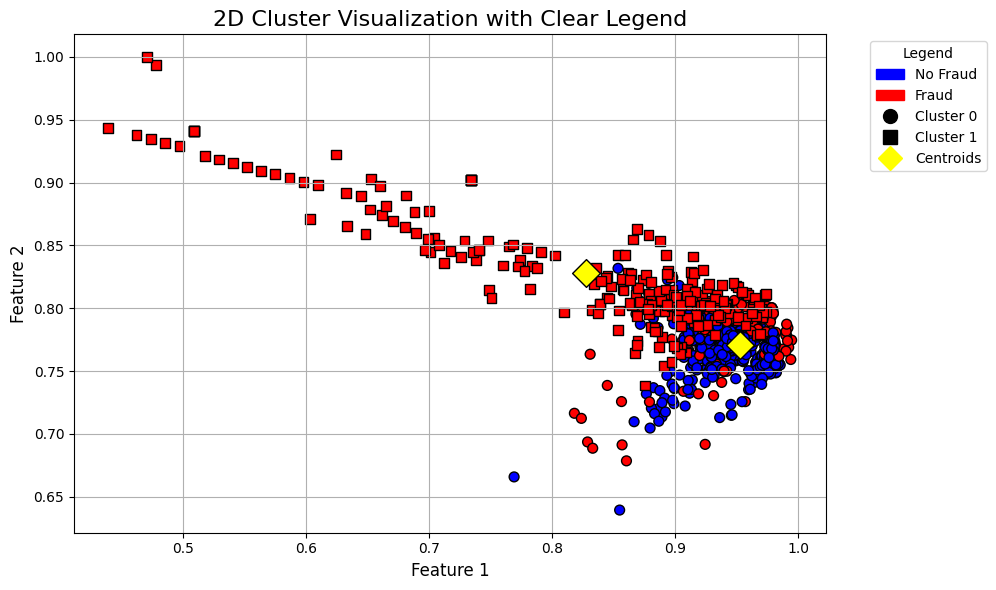

In [262]:

def plot_2d_clusters(X, y, cluster_labels, cluster_centroids=None):
    """
    Plot 2D clusters with clear and dynamic legends for fraud/no-fraud and cluster assignments.
    
    Parameters:
        X (np.ndarray): 2D array of shape (n_samples, 2) with features.
        y (np.ndarray): 1D binary array indicating fraud (0 or 1).
        cluster_labels (np.ndarray): 1D array indicating cluster assignment.
        cluster_centroids (np.ndarray): 2D array of cluster centroids (optional).
    """
    plt.figure(figsize=(10, 6))
    fraud_palette = {0: "blue", 1: "red"}  # Fraud/No-Fraud color palette

    # Create cluster markers dynamically
    unique_clusters = np.unique(cluster_labels)
    cluster_markers = ['o', 's', 'X', 'P', '*', 'D', '^', '+', '<', '>']  # Marker styles for clusters
    marker_map = {cluster: cluster_markers[i % len(cluster_markers)] for i, cluster in enumerate(unique_clusters)}

    # Plot points by clusters
    for cluster in unique_clusters:
        mask = cluster_labels == cluster
        fraud_mask = y[mask]
        plt.scatter(
            X[mask, 0],
            X[mask, 1],
            c=[fraud_palette[f] for f in fraud_mask],
            marker=marker_map[cluster],
            label=f"Cluster {cluster}" if cluster != -1 else "Outliers (-1)",
            s=50,
            edgecolor="k",  # Add border to markers for better clarity
        )

    # Add fraud/no-fraud legend manually
    fraud_legend = [
        mpatches.Patch(color="blue", label="No Fraud"),
        mpatches.Patch(color="red", label="Fraud"),
    ]

    # Combine fraud legend with cluster labels dynamically
    cluster_handles = [
        mlines.Line2D([], [], color="black", marker=marker_map[cluster], linestyle="None", markersize=10,
                      label=f"Cluster {cluster}" if cluster != -1 else "Outliers (-1)")
        for cluster in unique_clusters
    ]
    handles = fraud_legend + cluster_handles

    if cluster_centroids is not None:
        plt.scatter(
            cluster_centroids[:, 0],
            cluster_centroids[:, 1],
            c="yellow",  # Centroid color
            marker="D",  # Diamond shape for centroids
            s=200,
            edgecolor="black",
            label="Centroids",
        )
        centroid_handle = mlines.Line2D([], [], color="yellow", marker="D", linestyle="None", markersize=12, label="Centroids")
        handles += [centroid_handle]

    plt.legend(handles=handles, title="Legend", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to accommodate the legend

    # Plot enhancements
    plt.title("2D Cluster Visualization with Clear Legend", fontsize=16)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



kmeans = fit_kmeans(X_train, 2)
train_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_train)

kmeans_centroids = kmeans.cluster_centers_

# Here the clusters are fitted in all dimensions but only first two are plotted
plot_2d_clusters(X_train, y_train, train_cluster_labels, kmeans_centroids)

## PCA



In [295]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_full_pca = pca.transform(X_scale)

### Kmeans

In [296]:
# find the optimal number of clusters
pca_clustering, pca_classification = score_kmeans(X_train_pca, X_test_pca, y_train, y_test)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(2))
pca_classification_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.51       0.81       0.56     0.49      0.82      0.60
1           3      0.63       0.78       0.79     0.54      0.78      0.81
2           5      0.83       0.42       0.79     0.78      0.43      0.81
3          10      0.74       0.43       0.86     0.78      0.42      0.89


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
3,10,0.97,0.91,0.87,0.95,0.97,0.92,0.90,0.95


   accuracy    f1  recall  precision
0       1.0  0.79    0.79       0.79


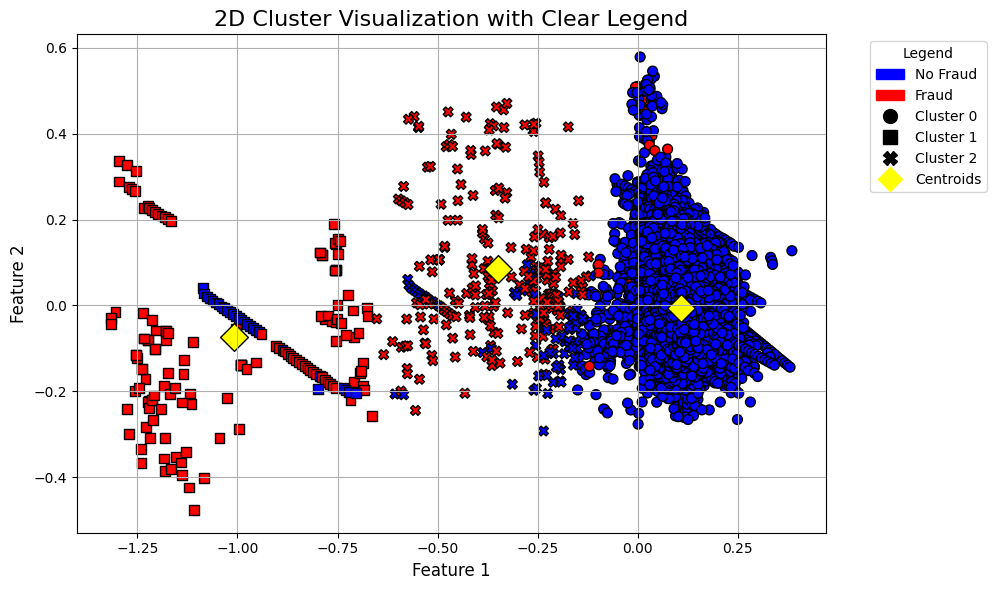

In [297]:
# test on full data
k = 3 # selected from the previous analysis
kmeans = fit_kmeans(X_train_pca, k)
full_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_full_pca)
full_kmeans_centroids = kmeans.cluster_centers_

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels, full_kmeans_centroids)

### DBSCAN

In [307]:
# find the optimal number of clusters
eps = np.arange(0.05, 0.1, 0.005)
pca_clustering, pca_classification = score_dbscan(X_train_pca, X_test_pca, y_train, y_test, eps)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(3))
pca_classification_df.round(2)

     eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.050     1.650      0.715      0.823    2.043     0.702     0.836
1  0.055     1.643      0.721      0.821    2.396     0.700     0.836
2  0.060     1.617      0.715      0.813    2.428     0.708     0.826
3  0.065     1.724      0.720      0.810    1.632     0.716     0.826
4  0.070     1.268      0.746      0.810    0.819     0.727     0.826
5  0.075     1.353      0.766      0.795    0.922     0.763     0.816
6  0.080     1.396      0.766      0.795    0.922     0.763     0.816
7  0.085     0.700      0.677      0.150    0.362     0.767     0.212
8  0.090     0.620      0.539      0.150    0.362     0.767     0.212
9  0.095     0.540      0.373      0.148    0.362     0.767     0.212


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.05,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
1,0.06,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
2,0.06,0.96,0.90,0.81,0.99,0.96,0.90,0.83,0.99
3,0.06,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
4,0.07,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
5,0.07,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
6,0.08,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
7,0.08,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
8,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
9,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00


   accuracy    f1  recall  precision
0       1.0  0.75    0.76       0.75


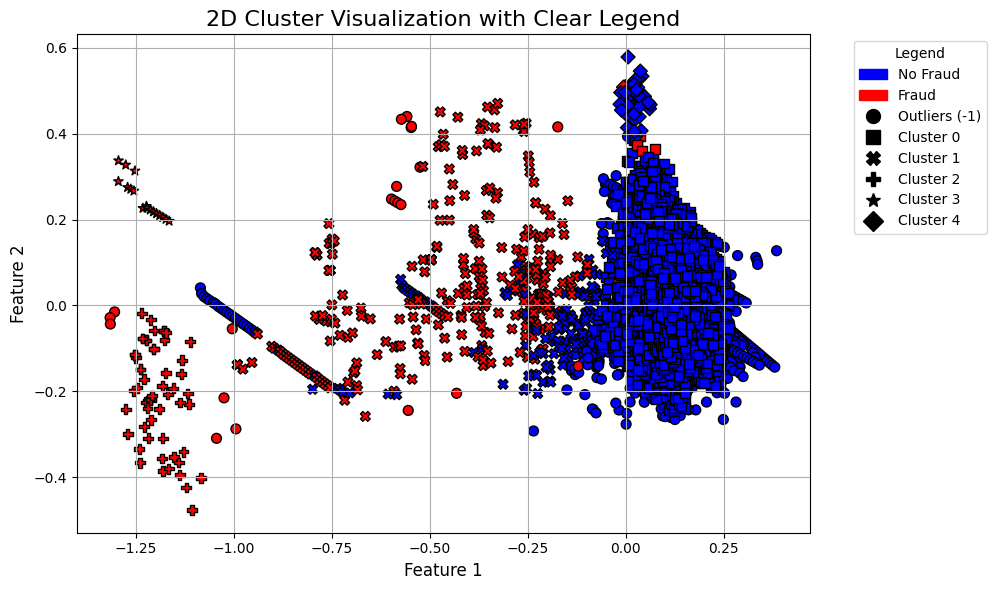

In [308]:
eps = 0.07
dbscan = fit_dbscan(X_train_pca, eps)

full_cluster_labels = test_dbscan(dbscan, X_train_pca, X_full_pca)

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels)
